# Estimation of tree height using GEDI dataset - Random Forest prediction

## Jupyterlab setup and libraries retrieving **[Just for UBUNTU 24.04]**

To run this lesson properly on osboxes.org you need to have a clean install of jupyterlab using the command line.
If you didn't do it for the previous lesson (Python data analysis or Python geospatial analysis), do it for this one, directly on the terminal:

    pipx uninstall jupyterlab
    pipx install --system-site-packages jupyterlab

and just after that, you can procede to install python libraries, using the apt install always in the terminal:

    sudo apt install python3-numpy python3-pandas python3-sklearn python3-matplotlib python3-rasterio python3-geopandas python3-seaborn python3-skimage python3-xarray

## Jupyterlab setup and libraries retrieving **[Just for OSGEOLIVE16]**

In order to run this notebook you need to run this command lines in your terminal:

    source $HOME/venv/bin/activate
    sudo apt update
    sudo apt install python3-pip
    pip3 install pyspatialml

after that all other needed libraries directly on jupyter with the magic lines (!):

    !pip3 install "pandas>=2.2.2,<3.0.0" "numpy>=1.26.4,<2.0.0" "rasterio>=1.3.10,<2.0.0" "scikit-learn>=1.4.2,<2.0.0" "scipy>=1.13.0,<2.0.0" "matplotlib>=3.9.0,<4.0.0" "xarray>=2024.1.0,<2025.0.0"

## Data retrieving (>3GB)
  
    cd  /media/sf_LVM_shared/my_SE_data/exercise/
    pipx install gdown
    ~/.local/bin/gdown 1Y60EuLsfmTICTX-U_FxcE1odNAf04bd-
    tar -xvzf tree_height.tar.gz
    

## Open the notebook lesson

Open the lesson using the CL

    cd /media/sf_LVM_shared/my_SE_data/exercise
    jupyter-lab Tree_Height_03RF_pred_SM.ipynb

## Model definition

Find a relationship between tree height and enviromental predictors to be able to predict out side the GEDI observation.  
The model, in its simplest form, looks like the following:  

    y ~ f ( a*x1 + b*x2 + c*x3 + …)  + ε,  
   
where y is the **response variable**, the x's are **predictor variables**, and ε is the **associated error**.

### Different types of models

Parametric models – make assumptions about the underlying distribution of the data:

- Maximum likelihood classification,
- Discriminant analysis,
- General linear models (ex. linear regression)

Nonparametric models – make no assumptions about the underlying data distributions:

- Generalized additive models,
- Support Vector Machine,
- Artificial neural networks,
- Random Forest

## Random forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in **Classification** (containing categorical variables) and **Regression** (response continuous variables) problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.  

One of the most important features of the Random Forest Algorithm is that it can handle continuous and categorical variables predictors without any assamption on their data distribution, dimension, and even if the predictors are autocorrelated.

**Bagging**  
Bagging, also known as Bootstrap Aggregation is the ensemble technique used by random forest. Choosesing a random sample from the data set it is creating a tree. Each tree is generated from the samples (Bootstrap Samples) provided by the Original Data with replacement known as row sampling. This step of row sampling with replacement is called bootstrap.
Each is trained independently which generates results. The final output is based on majority voting after combining the results of all models. This step which involves combining all the results and generating output based on majority voting is known as tree aggregation.


**Steps involved in random forest algorithm:**  

* Step 1: In Random forest n number of random records are taken from the data set having k number of records.  

* Step 2: Individual decision trees are constructed for each sample.  

* Step 3: Each decision tree will generate an output.  
* Step 4: Final output is considered based on Majority Voting or Averaging for Classification and regression respectively.  
 
(source https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/)

![RandomForest](https://www.researchgate.net/publication/354354484/figure/fig4/AS:1080214163595269@1634554534720/Illustration-of-random-forest-trees.jpg)

## **Random Forest test**   
In this exercise we will use Random Forest Regression algorithm with the [sklearn](https://scikit-learn.org/stable/) python package to estimage the tree height. 
In last step, we will see how it was possible to have a prediction on a raster  using [Pyspatialml](https://pyspatialml.readthedocs.io/en/latest/index.html) library (now deprecated) and how we can to the same but using the updated more robust [Xarray](https://docs.xarray.dev/en/stable/getting-started-guide/index.html) and [Rasterio](https://rasterio.readthedocs.io/en/stable/intro.html) libraries for the spatial prediction on the raster files.

In [2]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)

## Data analysis

Before everything we need to import the raw data, within the extracted predictors and show whole the data distribution

In [3]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)

# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [6]:
print("NUMBER OF ROWS:",len(predictors))

NUMBER OF ROWS: 1267239


To deeper analyze data distribution its always good to plot them

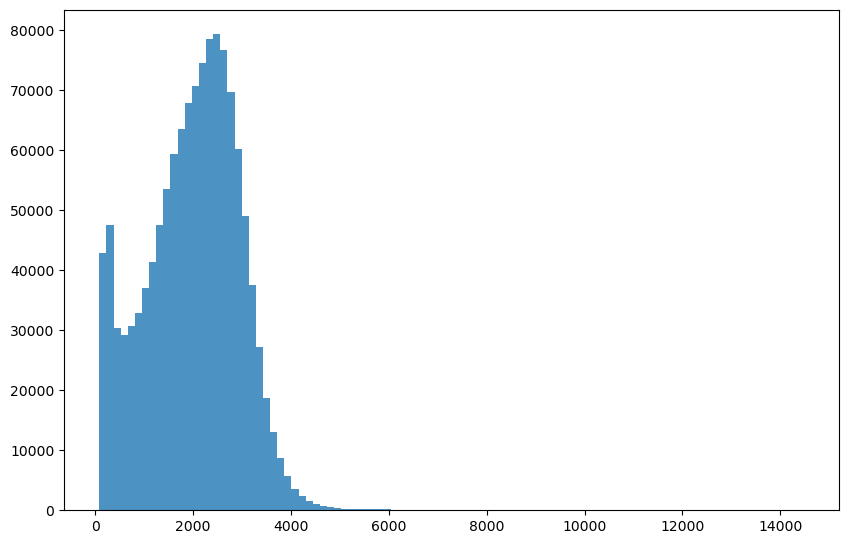

In [7]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

In this way we can see where the date spans to, and detect outliers.

Indeed, in this case we're gonna select only trees with height below 70m (because in this area, the highest tree detected in germany was 67m https://visit.freiburg.de/en/attractions/waldtraut-germany-s-tallest-tree).

And we procede sampling just 100K points out of the 1.2M, to train a lighter model.

In [24]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)

# add a height column in meter
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) 

# overlook
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
81999,82000,6.349125,49.644223,2659.75,26.5975,1530,16,2272,5931,21.476559,-141539392,1.694310,-0.040122,331.223236,23,631.313477,214.736084,365.218750,0.057163,25,717991,18.626610,451.421082,86
965362,965363,9.012956,49.690358,2689.50,26.8950,1536,12,2137,6537,15.065849,120771872,-1.399779,-0.072601,242.992401,26,353.459473,270.740967,220.016357,0.026610,9,719463,20.024574,492.804718,75
1236259,1236260,9.801078,49.395159,2572.00,25.7200,1528,16,2238,6472,16.836056,-162671216,0.910004,-0.033257,418.785919,20,-54.990723,61.513428,257.196045,0.045267,8,806762,19.990988,525.202148,82
1115641,1115642,9.382723,49.106039,2370.00,23.7000,1513,15,2407,6637,-24.503428,-231658992,-0.858004,-0.064393,267.034180,4,536.372314,470.607422,432.341064,0.030045,6,784144,19.837236,517.255615,29
215407,215408,6.773116,49.944617,1392.00,13.9200,1515,12,1952,6118,26.732821,-193019280,0.534557,-0.005609,300.268585,22,-162.502686,-200.892090,-412.381104,0.056135,15,666767,19.065788,437.629272,74
939859,939860,8.948157,49.643079,2365.25,23.6525,1481,13,2466,6341,-10.630081,-171884224,1.417312,-0.121560,400.390808,26,-52.929199,-124.971191,-149.944336,0.015808,9,737709,19.441750,473.700439,89
157727,157728,6.620174,49.837913,3160.75,31.6075,1536,13,2164,6052,-57.077930,-253935056,1.182596,-0.038630,343.578552,24,178.370117,86.893066,392.301758,-0.081356,23,675920,19.584587,443.499878,100
376387,376388,7.163473,49.791920,3010.00,30.1000,1352,12,2377,5621,-3.525097,-193161968,3.196814,0.090454,699.986816,22,435.113525,436.794434,406.962158,-0.108846,32,638925,22.397139,416.059174,87
426482,426483,7.277403,49.534507,277.75,2.7775,1494,15,2251,6162,7.484096,-268103968,0.745217,0.029769,391.105804,14,-40.088135,-26.999023,-72.698975,0.078123,12,641196,20.374083,485.715973,75
286481,286482,6.954634,48.417400,2362.50,23.6250,1331,20,3297,6108,15.627705,-346475904,0.985921,0.047404,547.931702,33,-2.996826,-0.247314,-181.765503,0.207945,50,960411,21.377501,454.721680,95


In [25]:
print("NUMBER OF ROWS:",len(predictors_sel))

NUMBER OF ROWS: 100000


Now we can see again the data distribution with the same plotting used before

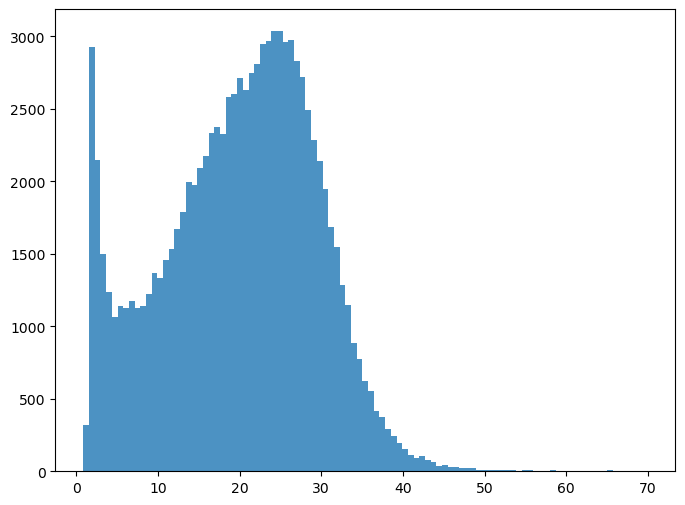

In [26]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

To have a comparison we'll analyze the **The Global Forest Canopy Height, 2019 map**.
This has been released in 2020 (within a scientific publication https://doi.org/10.1016/j.rse.2020.112165). 

The authors used a regression tree model that was calibrated and applied to each individual Landsat GLAD ARD tile (1° × 1°) in a “moving window” mode. 

This tree height estimation its available as forestheight.tiff and their extracted values available in the table as forestheight column.

To see how this model performed we can see a correlation plot and its calculated pearson coefficient.

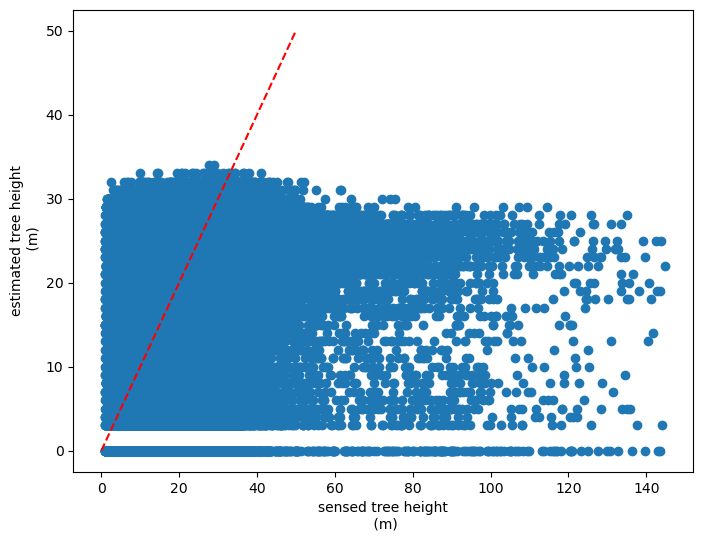

In [27]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(predictors['h']/100,predictors['forestheight'])
plt.xlabel('sensed tree height\n (m)')
plt.ylabel('estimated tree height\n (m)')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [28]:
# calculating the pearson correlation index
pearsonr_Publication_Estimation = pearsonr(predictors['h'],predictors['forestheight'])[0]

print("PEARSON CORRELATION COEFFINCENT:", pearsonr_Publication_Estimation)

PEARSON CORRELATION COEFFINCENT: 0.4527925130004339


In this procedure we will try to outperform this model Pearson Correlation Coefficent.

To do that we're gonna use a more advanced Machine Learning architecture with some more and different enviromental predictors that could better express the ecological asset and the physical conditions.

## Data set splitting

To procede we need to split the dataset (*predictors_sel*) in order to create the response variable table that will be used against the predictors variables (excluding the forestheight predictors).

In [29]:
X = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].values
Y = predictors_sel.iloc[:,4:5].values
feat = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].columns.values

Its always good to double check that we select the right columns in the right order

In [30]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [31]:
print("RESPONSE VARIABLE DIMENSION:", Y.shape)

RESPONSE VARIABLE DIMENSION: (100000, 1)


In [32]:
print("PREDICTING FEATURES DIMENSION:", X.shape)

PREDICTING FEATURES DIMENSION: (100000, 18)


Now we can create 4 different dataset:
- 2 for model algorithm training (*X_train* and *Y_train*)
- 2 for model testing (*X_test* and *Y_test*) 

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Random Forest default parameters

Random Forest can be implemented using the [RandomForestRegressor in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We can procede on training the Random Forest model using its default parameters.

In [41]:
rf = RandomForestRegressor(random_state = 42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [42]:
rfReg = RandomForestRegressor(min_samples_leaf=50, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
print("PEARSON CORRELATION COEFFINCENT:", pearsonr_all)

PEARSON CORRELATION COEFFINCENT: [0.6035710046325166, 0.506707480767017]


In [45]:
# checking the oob score
print("OUT OF BAG SCORE:", rfReg.oob_score_)

OUT OF BAG SCORE: 0.2625683482738882


Additional resources that can be used to reduce more the oob error can be found at:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

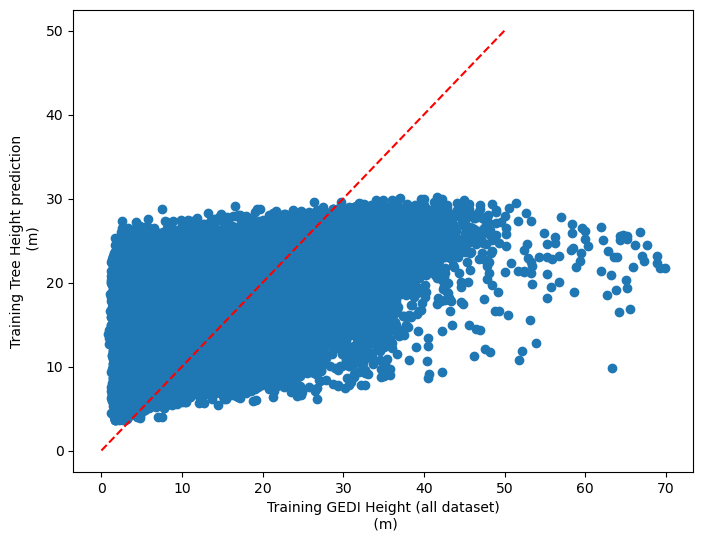

In [52]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('Training GEDI Height (all dataset)\n (m)')
plt.ylabel('Training Tree Height prediction\n (m)')
ident = [0, 50]
plt.plot(ident,ident,'r--')

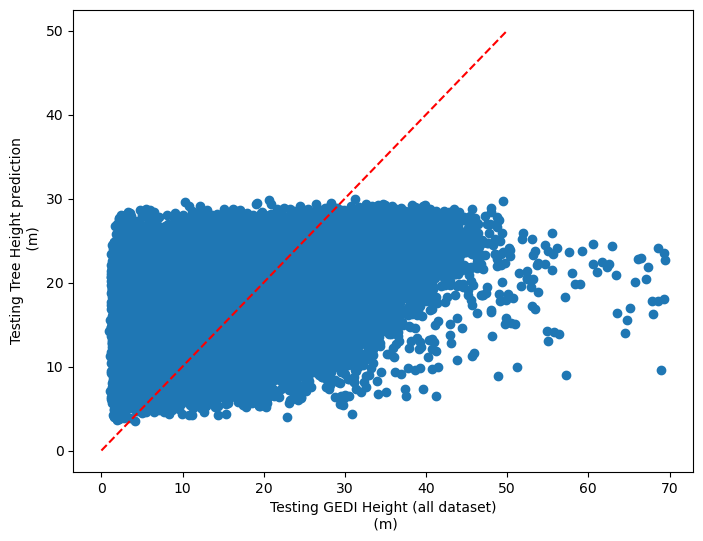

In [47]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('Testing GEDI Height (all dataset)\n (m)')
plt.ylabel('Testing Tree Height prediction\n (m)')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [54]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [55]:
ind

array([ 1, 13,  0,  4,  6,  8, 16,  2, 15,  5, 12,  3, 11,  9, 14,  7, 10,
       17])


To deeper analyze model behaviour in response variable regression we can extract the Feature Importance Ranking

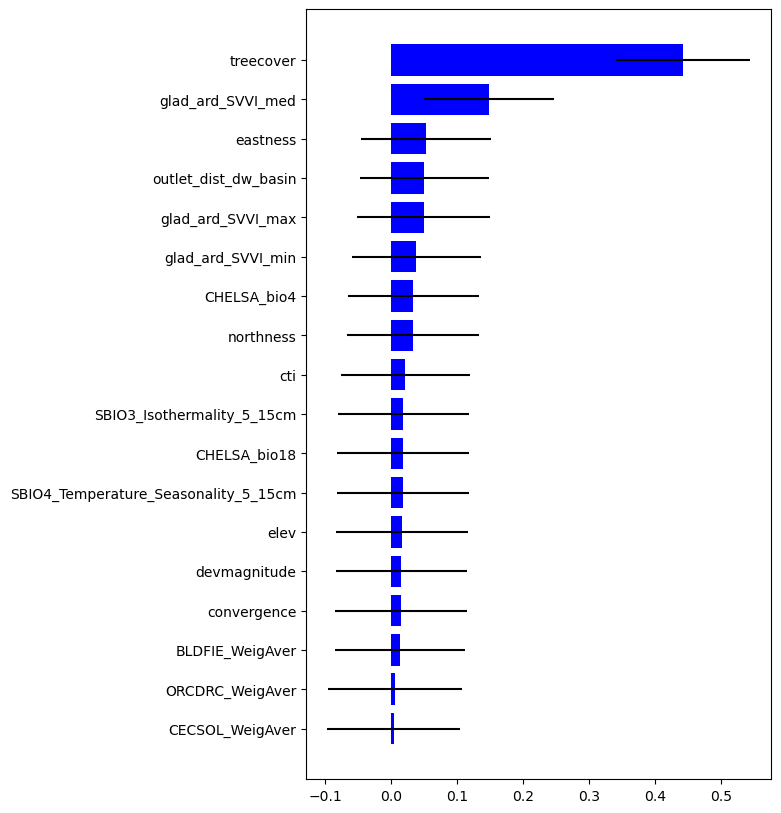

In [56]:
plt.rcParams["figure.figsize"] = (6,10)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

## Model tuning whith Hyperparameters Tweeking

To improve model performance we can use tools like *GridSearchCV* to find with a recursive search the best combination of all model hyperparameters imployed.

Hyperparameters that were setted as default in the first model run, like:
* "max_features": number of features to consider when looking for the best split. 
* "max_samples": number of samples to draw from X to train each base estimator.
* "n_estimators": identify the number of trees that must grow. It must be large enough so that the error is stabilized. Defoult 100.
* "max_depth": max number of levels in each decision tree.

By using this code we can tune up those parameters to improve the algoirithm performance (this code is not runned directly because of its big computational demand as for time and memory perspective)


    pipeline = Pipeline([('rf',RandomForestRegressor())])

    parameters = {
            'rf__max_features':(3,4,5),
            'rf__max_samples':(0.5,0.6,0.7),
            'rf__n_estimators':(500,1000),
            'rf__max_depth':(50,100,200,300)}

    grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
    grid_search.fit(X_train,y_train)
    

    rfReg = RandomForestRegressor(n_estimators=5000,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True) 
    rfReg.fit(X_train, y_train); 
    dic_pred = {} 
    dic_pred['train'] = rfReg.predict(X_train) 
    dic_pred['test'] = rfReg.predict(X_test) 
    pearsonr_all_tune = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]] 
    pearsonr_all_tune

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_) 
    print ('Optimal parameters:') best_par = grid_search.best_estimator_.get_params() 
    for par_name in sorted(parameters.keys()): 
        print ('\t%s: %r' % (par_name, best_par[par_name]))
        
Tracking the error rate trend as in https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

Features importance ranking shows that the most important variable is treecover followed by Spectral Variability Vegetation Index, and outlet_dist_dw_basin which is a proxy of water accumulation.

Besides eastness and northness describes microclimat condition.

## Model tuning with data selection

We can enhance the model performance also by having a wise data selection.

In this case we can have it based on data quality flag (available in the dataset) to select more reilable tree height points.

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (beter )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [57]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
0,1,6.050001,49.727499,3139,3139,3139,3120,3139,3139,3120,3139,5,410.0,383.72153,1,1,1,1,1,1,0.962,0.984,0.968,0.962,0.989,0.979,0,17.7
1,2,6.050002,49.922155,1022,2303,970,872,5596,1524,872,5596,5,290.0,2374.14110,0,0,0,0,0,0,0.948,0.990,0.960,0.948,0.994,0.980,0,43.7
2,3,6.050002,48.602377,380,1336,332,362,1336,1340,332,1340,4,440.0,435.97781,1,1,1,1,1,1,0.947,0.975,0.956,0.947,0.981,0.968,0,0.2
3,4,6.050009,48.151979,3153,3142,3142,3127,3138,3142,3127,3153,2,450.0,422.00537,1,1,1,1,1,1,0.930,0.970,0.943,0.930,0.978,0.962,0,-14.2
4,5,6.050010,49.588410,666,4221,651,33,5611,2723,33,5611,8,370.0,2413.74830,0,0,0,0,0,0,0.941,0.983,0.946,0.941,0.992,0.969,0,22.1
5,6,6.050014,48.608456,787,1179,1187,761,1833,1833,761,1833,3,420.0,415.51581,1,1,1,1,1,1,0.952,0.979,0.961,0.952,0.986,0.975,0,0.2


In [58]:
height_6algorithms_sel = height_6algorithms.loc[(height_6algorithms['BEAM'] > 4) 
                                            &   (height_6algorithms['qc_a1'] == 1)
                                            &   (height_6algorithms['qc_a2'] == 1)
                                            &   (height_6algorithms['qc_a3'] == 1)    
                                            &   (height_6algorithms['qc_a4'] == 1)    
                                            &   (height_6algorithms['qc_a5'] == 1)    
                                            &   (height_6algorithms['qc_a6'] == 1)
                                            &   (height_6algorithms['se_a1'] > 0.95)    
                                            &   (height_6algorithms['se_a2'] > 0.95)
                                            &   (height_6algorithms['se_a3'] > 0.95)
                                            &   (height_6algorithms['se_a4'] > 0.95)
                                            &   (height_6algorithms['se_a5'] > 0.95)   
                                            &   (height_6algorithms['se_a6'] > 0.95)
                                            &   (height_6algorithms['deg_fg'] == 0)  
                                            &   (height_6algorithms['solar_ele'] < 0)]

In [59]:
height_6algorithms_sel

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
7,8,6.050019,49.921613,3303,3288,3296,3236,3857,3292,3236,3857,7,320.0,297.68533,1,1,1,1,1,1,0.971,0.988,0.976,0.971,0.992,0.984,0,-33.9
11,12,6.050039,47.995344,2762,2736,2740,2747,3893,2736,2736,3893,5,390.0,368.55121,1,1,1,1,1,1,0.975,0.990,0.979,0.975,0.994,0.987,0,-37.3
14,15,6.050046,49.865317,1398,2505,2509,1316,2848,2505,1316,2848,6,340.0,330.40564,1,1,1,1,1,1,0.973,0.990,0.979,0.973,0.994,0.986,0,-18.2
15,16,6.050048,49.050020,984,943,947,958,2617,947,943,2617,6,300.0,291.22598,1,1,1,1,1,1,0.978,0.991,0.982,0.978,0.995,0.988,0,-35.4
16,17,6.050049,48.391359,3362,3332,3336,3351,4467,3336,3332,4467,5,530.0,504.78122,1,1,1,1,1,1,0.973,0.988,0.977,0.973,0.992,0.984,0,-5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267207,1267208,9.949829,49.216272,2160,2816,2816,2104,3299,2816,2104,3299,8,420.0,386.44556,1,1,1,1,1,1,0.980,0.993,0.984,0.980,0.995,0.989,0,-16.9
1267211,1267212,9.949856,49.881190,3190,3179,3179,3171,3822,3179,3171,3822,6,380.0,363.69348,1,1,1,1,1,1,0.968,0.986,0.974,0.968,0.990,0.982,0,-35.1
1267216,1267217,9.949880,49.873435,2061,2828,2046,2024,2828,2828,2024,2828,7,380.0,361.06812,1,1,1,1,1,1,0.967,0.988,0.974,0.967,0.993,0.983,0,-35.1
1267227,1267228,9.949958,49.127182,366,2307,1260,355,3531,2719,355,3531,6,500.0,493.52792,1,1,1,1,1,1,0.973,0.989,0.978,0.973,0.993,0.985,0,-36.0


Calculate the mean height excluidng the maximum and minimum values 

In [60]:
height_sel =  pd.DataFrame({'ID' : height_6algorithms_sel['ID'] , 
                            'hm_sel': (height_6algorithms_sel['a1_95'] + height_6algorithms_sel['a2_95'] + height_6algorithms_sel['a3_95'] + height_6algorithms_sel['a4_95'] 
                             + height_6algorithms_sel['a5_95'] + height_6algorithms_sel['a6_95'] - height_6algorithms_sel['min_rh_95'] - height_6algorithms_sel['max_rh_95']) / 400 } )

In [61]:
height_sel

,ID,hm_sel
7,8,32.9475
11,12,27.4625
14,15,22.2925
15,16,9.5900
16,17,33.4625
...,...,...
1267207,1267208,26.5200
1267211,1267212,31.8175
1267216,1267217,24.4075
1267227,1267228,16.6300


Merge the new height with the predictors table, using the ID as Primary Key

In [62]:
predictors_hm_sel = pd.merge( predictors ,  height_sel , left_on='ID' ,  right_on='ID' ,  how='right')

In [63]:
predictors_hm_sel.head(6)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
0,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86,32.9475
1,12,6.050039,47.995344,2746.25,1523,12,2612,6181,3.549103,-71279992,0.507727,-0.021408,322.920227,26,660.006104,92.722168,190.979736,-0.034787,16,784807,20.798000,460.501221,97,27.4625
2,15,6.050046,49.865317,2229.25,1517,13,2191,5901,31.054762,-186807440,-1.375050,-0.126880,291.412537,7,1028.385498,915.806396,841.586182,0.024677,16,766444,19.941267,454.185089,54,22.2925
3,16,6.050048,49.050020,959.00,1526,14,2081,6100,9.933455,-183562672,-0.382834,0.086874,246.288010,24,-12.283691,-58.179199,174.205566,0.094175,10,805730,19.849365,470.946533,78,9.5900
4,17,6.050049,48.391359,3346.25,1489,19,2486,5966,-6.957157,-273522688,2.989759,0.214769,474.409088,24,125.583008,6.154297,128.129150,0.017164,15,950190,21.179420,491.398376,85,33.4625
5,19,6.050053,49.877876,529.00,1531,12,2184,5915,-24.278454,-377335296,0.265329,-0.248356,335.534760,25,593.601074,228.712402,315.298340,-0.127365,17,764713,19.760756,448.580811,96,5.2900


In [64]:
predictors_hm_sel = predictors_hm_sel.loc[(predictors['h'] < 7000) ].sample(100000)

In [65]:
predictors_hm_sel

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
67109,358075,7.121301,48.393362,3127.00,1390,14,3278,6149,-18.622808,-349385216,1.205495,0.221449,628.071411,28,16.379883,-1.361572,-254.569824,0.122928,30,870714,21.026922,455.862976,89,31.2700
49443,271106,6.915753,48.398865,2755.00,1403,16,2880,6227,-10.780100,-364243424,0.597950,0.212738,479.239380,28,94.056396,13.479736,-101.955322,0.052124,26,956659,20.500694,460.670288,85,27.5500
225998,1262978,9.924864,49.878408,2404.25,1497,14,2044,6528,-5.170033,-260566736,1.070872,-0.060704,322.041046,20,256.728516,15.479248,-28.410645,0.124602,8,855708,19.397581,507.361115,78,24.0425
46927,257606,6.880155,49.368619,2322.00,1514,15,2292,6233,11.174547,-242390336,-0.602614,-0.084595,268.367157,20,236.149902,236.915039,371.205322,-0.050283,11,769062,21.441999,496.682587,58,23.2200
27199,146987,6.582437,49.476879,2464.25,1521,14,2117,6219,-6.374312,-234200800,-1.728040,0.231585,182.034286,23,73.248047,19.785400,249.853027,0.019138,11,731353,20.218201,483.040649,93,24.6425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25984,139170,6.551567,49.175072,2125.00,1511,17,2252,6015,-14.249553,-248558160,2.698703,-0.056752,371.123718,25,141.861816,2.110840,86.527588,0.024905,12,800114,20.031235,479.971527,85,21.2500
46950,257777,6.880572,49.535945,231.00,1519,14,2161,6189,32.561085,89643480,-1.137112,-0.001126,286.474335,0,937.622314,743.368652,405.727051,-0.008619,10,787605,21.355637,486.371185,4,2.3100
160836,912341,8.879877,48.959728,1810.50,1518,15,2200,6501,-45.779213,-249658704,0.581574,0.009894,277.630981,23,321.381836,71.376465,304.113281,-0.130948,15,832408,18.087175,476.243561,99,18.1050
100900,558839,7.634858,49.360323,2422.75,1533,11,2377,6304,-23.222776,-286424256,0.680885,0.017598,367.074890,25,-84.395996,-98.640869,22.901367,-0.179092,10,895793,18.074240,468.273102,80,24.2275


In [66]:
X = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].values
Y = predictors_hm_sel.iloc[:,23:24].values
feat = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].columns.values

In [69]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [70]:
print("RESPONSE VARIABLE DIMENSION:", Y.shape)

RESPONSE VARIABLE DIMENSION: (100000, 1)


In [71]:
print("PREDICTING FEATURES DIMENSION:", X.shape)

PREDICTING FEATURES DIMENSION: (100000, 18)


In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Model run using default parameters and wuality flag selected data

Training Random Forest using default parameters

In [73]:
rfReg = RandomForestRegressor(min_samples_leaf=20, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)

In [74]:
# checking the oob score
print("OUT OF BAG SCORE:", rfReg.oob_score_)

OUT OF BAG SCORE: 0.37252902906812235


In [75]:
pearsonr_all_sel = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
print("PEARSON CORRELATION COEFFINCENT:", pearsonr_all_sel)

PEARSON CORRELATION COEFFINCENT: [0.746007848830619, 0.6125852590365624]


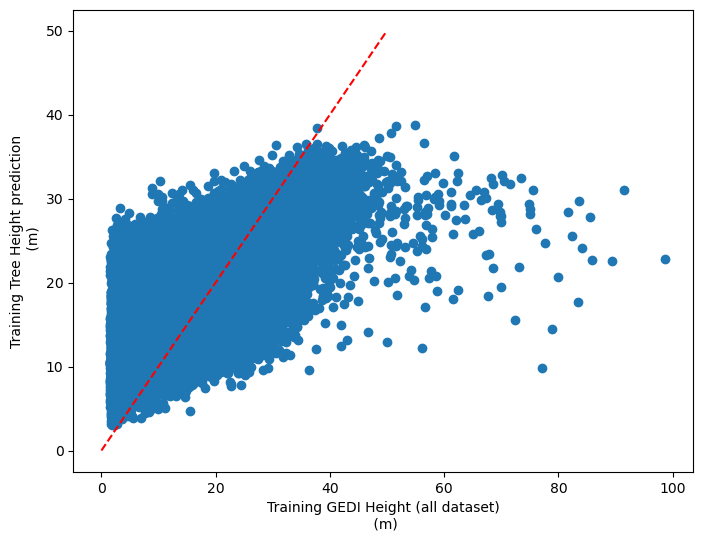

In [85]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('Training GEDI Height (all dataset)\n (m)')
plt.ylabel('Training Tree Height prediction\n (m)')
ident = [0, 50]
plt.plot(ident,ident,'r--')

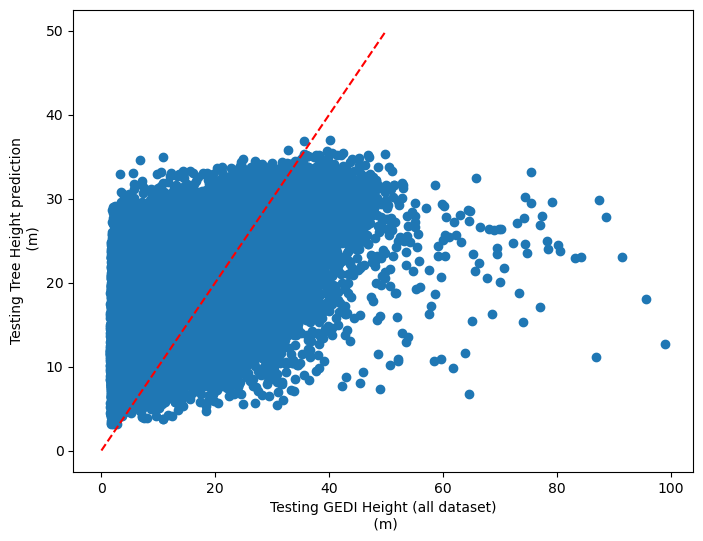

In [87]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('Testing GEDI Height (all dataset)\n (m)')
plt.ylabel('Testing Tree Height prediction\n (m)')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [88]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [89]:
ind

array([ 1, 13,  0,  4, 16,  6,  8, 15,  5,  2, 11,  3, 12,  9, 14,  7, 10,
       17])

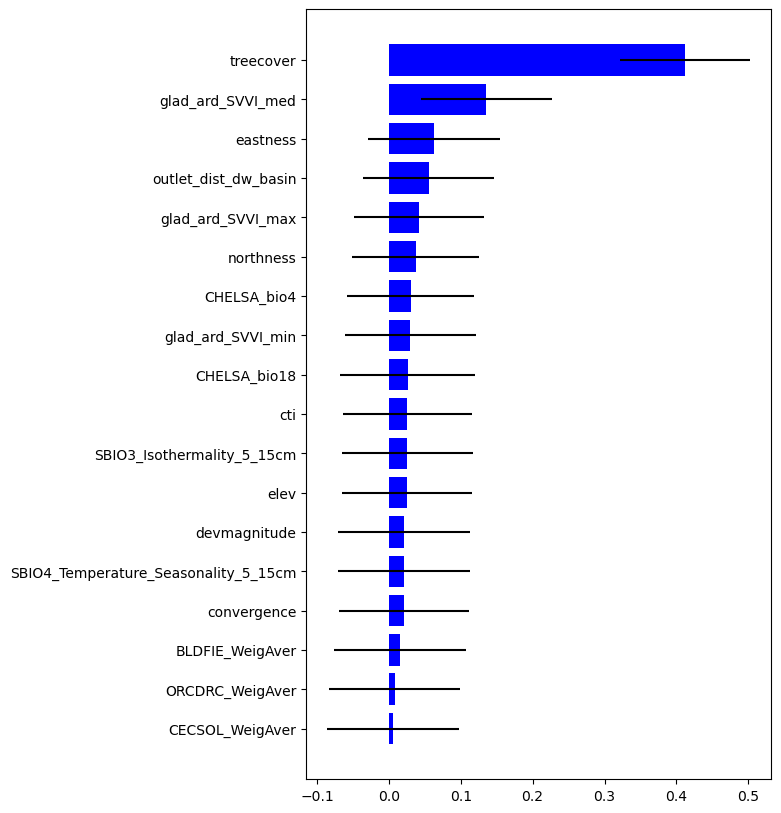

In [91]:
plt.rcParams["figure.figsize"] = (6,10)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

## Model Final Assesment

we can do a comparison between published model performance and ours.

**Global Forest Canopy Height, 2019**

In [78]:
print("PEARSON CORRELATION INDEX:", pearsonr_Publication_Estimation)

PEARSON CORRELATION INDEX: 0.4527925130004339


**Random Forest Model [100k GEDI subset] [fine tuning=NO] [data selection=NO]**

In [81]:
print("PEARSON CORRELATION COEFFINCENT:", pearsonr_all)

PEARSON CORRELATION COEFFINCENT: [0.6035710046325166, 0.506707480767017]


**Random Forest Model [100k GEDI subset] [fine tuning=NO] [data selection=YES]**

In [83]:
print("PEARSON CORRELATION COEFFINCENT:", pearsonr_all_sel)

PEARSON CORRELATION COEFFINCENT: [0.746007848830619, 0.6125852590365624]



If we want to improve even more the selected data model, we can perform again a GridSearch hyperparameter fine tuning

    pipeline = Pipeline([('rf',RandomForestRegressor())])
    
    parameters = {
        'rf__max_features':("log2","sqrt",0.33),
        'rf__max_samples':(0.5,0.6,0.7),
        'rf__n_estimators':(500,1000),
        'rf__max_depth':(50,100,200)}
    grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=3,scoring='r2',verbose=1)
    grid_search.fit(X_train,y_train)

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_)
    print ('Optimal parameters:')
    best_par = grid_search.best_estimator_.get_params()
    for par_name in sorted(parameters.keys()):
        print ('\t%s: %r' % (par_name, best_par[par_name]))

    rfReg = RandomForestRegressor(n_estimators=500,max_features='sqrt',max_depth=50,max_samples=0.6,n_jobs=-1,random_state=24)
    rfReg.fit(X_train, y_train);
    dic_pred = {}
    dic_pred['train'] = rfReg.predict(X_train)
    dic_pred['test'] = rfReg.predict(X_test)
    [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]

## Model Prediction on Raster

### Predict on the raster using pyspatialml (deprecated library)

    # import Global Landsat Analysis Ready Data
    glad_ard_SVVI_min = "tree_height/geodata_raster/glad_ard_SVVI_min.tif"
    glad_ard_SVVI_med = "tree_height/geodata_raster/glad_ard_SVVI_med.tif"
    glad_ard_SVVI_max = "tree_height/geodata_raster/glad_ard_SVVI_max.tif"
    
    # import climate data
    CHELSA_bio4 = "tree_height/geodata_raster/CHELSA_bio4.tif"
    CHELSA_bio18 = "tree_height/geodata_raster/CHELSA_bio18.tif"
    
    # import soil data
    BLDFIE_WeigAver = "tree_height/geodata_raster/BLDFIE_WeigAver.tif"
    CECSOL_WeigAver = "tree_height/geodata_raster/CECSOL_WeigAver.tif"
    ORCDRC_WeigAver = "tree_height/geodata_raster/ORCDRC_WeigAver.tif"
    
    # import geomorphological data (DEM derived)
    elev = "tree_height/geodata_raster/elev.tif"
    convergence = "tree_height/geodata_raster/convergence.tif"
    northness = "tree_height/geodata_raster/northness.tif"
    eastness = "tree_height/geodata_raster/eastness.tif"
    devmagnitude = "tree_height/geodata_raster/dev-magnitude.tif"
    
    # import hydrographic data (from hydrography90m)
    cti = "tree_height/geodata_raster/cti.tif"
    outlet_dist_dw_basin = "tree_height/geodata_raster/outlet_dist_dw_basin.tif"
    
    # import soil climate data
    
    SBIO3_Isothermality_5_15cm = "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif"
    SBIO4_Temperature_Seasonality_5_15cm = "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif"
    
    # import forest cover data
    
    treecover = "tree_height/geodata_raster/treecover.tif"

    from pyspatialml import Raster
    predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max,
                          CHELSA_bio4,CHELSA_bio18,
                          BLDFIE_WeigAver,CECSOL_WeigAver,ORCDRC_WeigAver,
                          elev,convergence,northness,eastness,devmagnitude,cti,outlet_dist_dw_basin,
                          SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover]
    
    stack = Raster(predictors_rasters)

    result = stack.predict(estimator=rfReg, dtype='int16', nodata=-1)

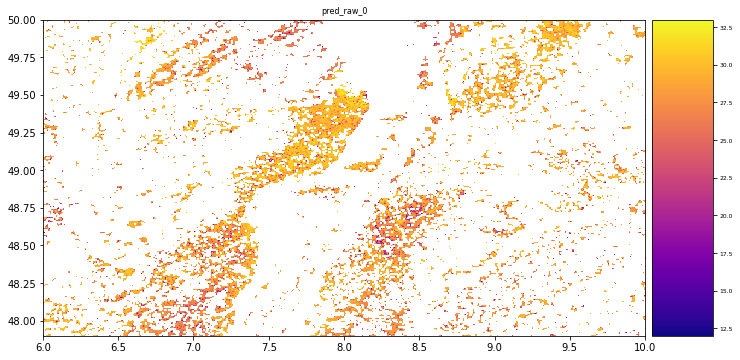

In [53]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

### Predict on the raster using xarray and rasterio (Full size 90m res raster prediction >12h)

    import xarray as xr
    import rasterio
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    import os
    
    # Define paths to raster files
    raster_paths = {
        'glad_ard_SVVI_min': "tree_height/geodata_raster/glad_ard_SVVI_min.tif",
        'glad_ard_SVVI_med': "tree_height/geodata_raster/glad_ard_SVVI_med.tif",
        'glad_ard_SVVI_max': "tree_height/geodata_raster/glad_ard_SVVI_max.tif",
        'CHELSA_bio4': "tree_height/geodata_raster/CHELSA_bio4.tif",
        'CHELSA_bio18': "tree_height/geodata_raster/CHELSA_bio18.tif",
        'BLDFIE_WeigAver': "tree_height/geodata_raster/BLDFIE_WeigAver.tif",
        'CECSOL_WeigAver': "tree_height/geodata_raster/CECSOL_WeigAver.tif",
        'ORCDRC_WeigAver': "tree_height/geodata_raster/ORCDRC_WeigAver.tif",
        'elev': "tree_height/geodata_raster/elev.tif",
        'convergence': "tree_height/geodata_raster/convergence.tif",
        'northness': "tree_height/geodata_raster/northness.tif",
        'eastness': "tree_height/geodata_raster/eastness.tif",
        'devmagnitude': "tree_height/geodata_raster/dev-magnitude.tif",
        'cti': "tree_height/geodata_raster/cti.tif",
        'outlet_dist_dw_basin': "tree_height/geodata_raster/outlet_dist_dw_basin.tif",
        'SBIO3_Isothermality_5_15cm': "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif",
        'SBIO4_Temperature_Seasonality_5_15cm': "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif",
        'treecover': "tree_height/geodata_raster/treecover.tif"
    }
    
    # Load raster files into an xarray Dataset
    raster_datasets = []
    for name, path in raster_paths.items():
        with rasterio.open(path) as src:
            # Read raster data and convert to xarray DataArray
            data = src.read(1)  # Read the first band
            coords = {
                'y': np.linspace(src.bounds.top, src.bounds.bottom, src.height),
                'x': np.linspace(src.bounds.left, src.bounds.right, src.width)
            }
            da = xr.DataArray(data, coords=coords, dims=['y', 'x'], name=name)
            raster_datasets.append(da)
    
    # Combine all DataArrays into a single Dataset
    stack = xr.merge(raster_datasets)
    
    # Prepare data for prediction
    # Convert the stack to a 2D array where each row is a pixel and columns are features
    feature_names = list(raster_paths.keys())
    data_array = stack.to_array(dim='variable').transpose('y', 'x', 'variable')
    data_2d = data_array.values.reshape(-1, len(feature_names))
    
    # Create a mask for valid data (exclude pixels where any predictor is NaN)
    valid_mask = ~np.any(np.isnan(data_2d), axis=1)
    valid_data = data_2d[valid_mask]
    
    # Predict tree heights for valid pixels using the trained RandomForestRegressor (rfReg)
    predictions = np.full(data_2d.shape[0], -1, dtype=np.int16)  # Initialize with nodata value
    predictions[valid_mask] = rfReg.predict(valid_data)
    
    # Reshape predictions back to the original raster shape
    pred_2d = predictions.reshape(data_array.shape[0], data_array.shape[1])
    
    # Save the prediction as a new raster file
    output_path = "tree_height/geodata_raster/predicted_tree_height.tif"
    with rasterio.open(
        list(raster_paths.values())[0],  # Use the first raster as a template for metadata
    ) as src:
        profile = src.profile
        profile.update(dtype=rasterio.int16, nodata=-1)
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(pred_2d, 1)
    
    # Plot the result using xarray
    ds_pred = xr.DataArray(pred_2d, coords={'y': stack.y, 'x': stack.x}, dims=['y', 'x'], name='predicted_height')
    ds_pred.plot(cmap='plasma', figsize=(12, 12))
    plt.title("Predicted Tree Height")
    plt.show()

### Predict on the raster using xarray and rasterio (1000x1000 UL corner tile for 90m res raster prediction)

In [92]:
# Define paths to raster files
raster_paths = {
    # import Global Landsat Analysis Ready Data
    'glad_ard_SVVI_min': "tree_height/geodata_raster/glad_ard_SVVI_min.tif", 
    'glad_ard_SVVI_med': "tree_height/geodata_raster/glad_ard_SVVI_med.tif",
    'glad_ard_SVVI_max': "tree_height/geodata_raster/glad_ard_SVVI_max.tif",
    # import climate data
    'CHELSA_bio4': "tree_height/geodata_raster/CHELSA_bio4.tif",
    'CHELSA_bio18': "tree_height/geodata_raster/CHELSA_bio18.tif",
    # import soil data
    'BLDFIE_WeigAver': "tree_height/geodata_raster/BLDFIE_WeigAver.tif",
    'CECSOL_WeigAver': "tree_height/geodata_raster/CECSOL_WeigAver.tif",
    'ORCDRC_WeigAver': "tree_height/geodata_raster/ORCDRC_WeigAver.tif",
    # import geomorphological data (DEM derived)
    'elev': "tree_height/geodata_raster/elev.tif",
    'convergence': "tree_height/geodata_raster/convergence.tif",
    'northness': "tree_height/geodata_raster/northness.tif",
    'eastness': "tree_height/geodata_raster/eastness.tif",
    'devmagnitude': "tree_height/geodata_raster/dev-magnitude.tif",
    # import hydrographic data (from hydrography90m)
    'cti': "tree_height/geodata_raster/cti.tif",
    'outlet_dist_dw_basin': "tree_height/geodata_raster/outlet_dist_dw_basin.tif",
    # import soil climate data
    'SBIO3_Isothermality_5_15cm': "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif",
    'SBIO4_Temperature_Seasonality_5_15cm': "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif",
    # import forest cover data
    'treecover': "tree_height/geodata_raster/treecover.tif"
}

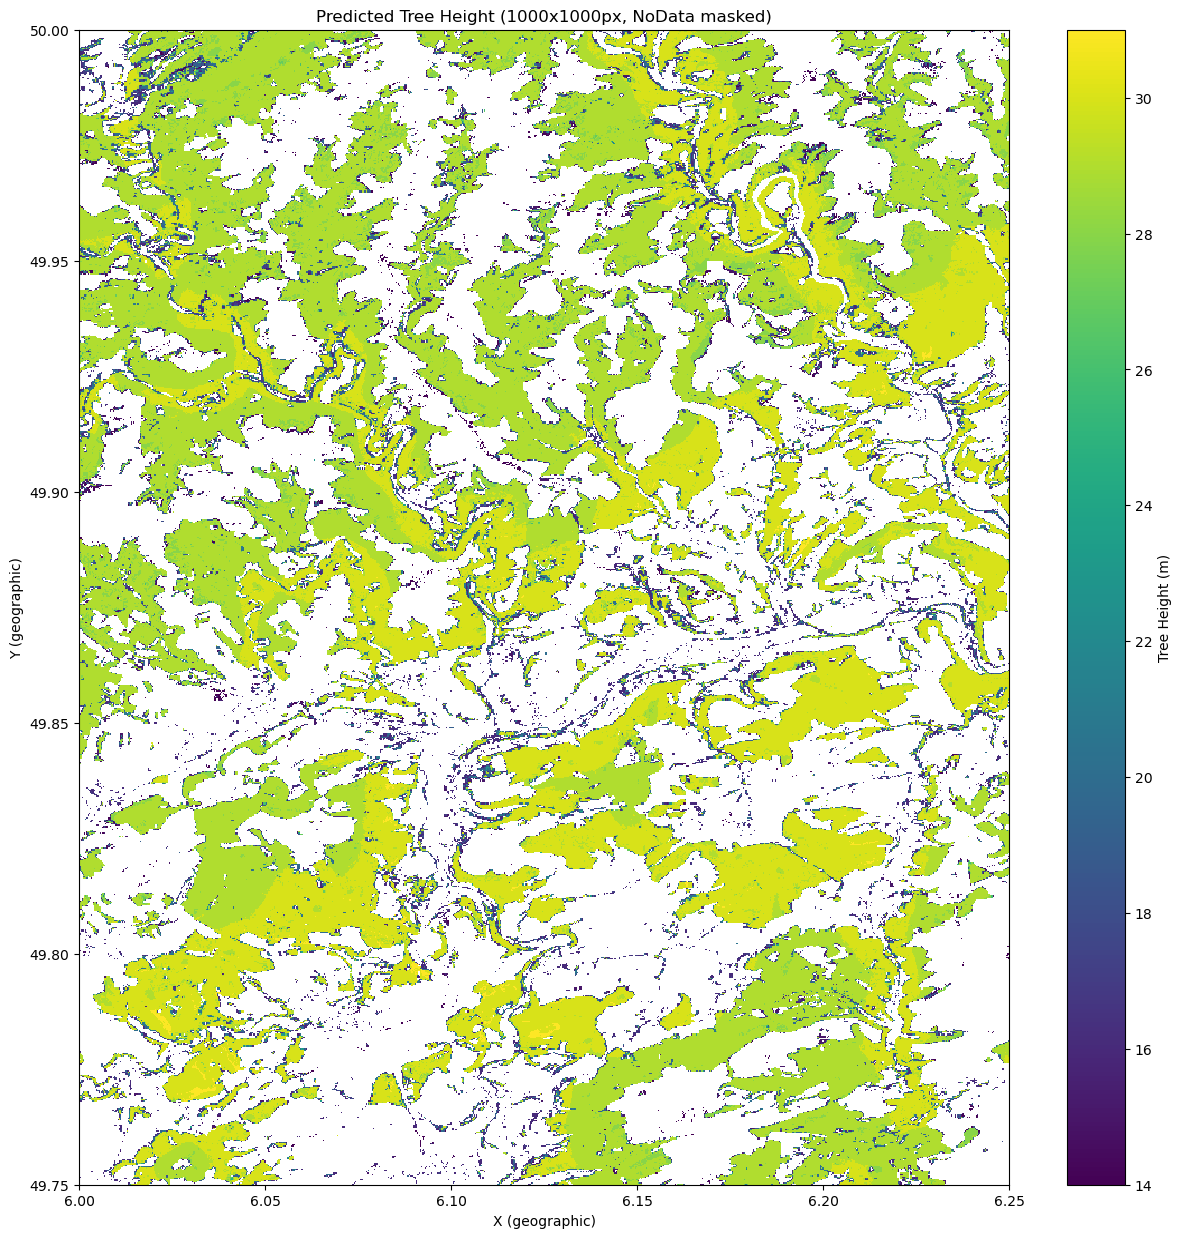

In [93]:
import xarray as xr
import rasterio
import rasterio.windows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Define a small window (1000x1000 UL corner) to avoid high time/computation demand
window = rasterio.windows.Window(0, 0, 1000, 1000)

# Load raster files into an xarray Dataset with NoData handling
raster_datasets = []
for name, path in raster_paths.items():
    with rasterio.open(path) as src:
        # Get NoData value from raster metadata
        nodata = src.nodata if src.nodata is not None else np.nan
        # Read data within the specified window
        data = src.read(1, window=window)
        
        # Replace raster-specific NoData values with np.nan for consistency
        if nodata is not np.nan:
            data = np.where(data == nodata, np.nan, data)
        
        # Transform coordinates for the window
        transform = src.window_transform(window)
        rows, cols = np.arange(window.height), np.arange(window.width)
        xs, ys = np.meshgrid(cols, rows)
        xs_geo, ys_geo = rasterio.transform.xy(transform, ys, xs)
        x_coords = np.array(xs_geo[0])  # X coordinates for columns
        y_coords = np.array([row[0] for row in ys_geo])  # Y coordinates for rows

        # Create xarray DataArray
        da = xr.DataArray(
            data,
            coords={'y': y_coords, 'x': x_coords},
            dims=['y', 'x'],
            name=name,
            attrs={'nodata': np.nan}  # Store NoData as NaN in attributes
        )
        raster_datasets.append(da)

# Combine all DataArrays into a single Dataset
stack = xr.merge(raster_datasets)

# Prepare data for prediction
# Convert the stack to a 2D array where each row is a pixel and columns are features
feature_names = list(raster_paths.keys())
data_array = stack.to_array(dim='variable').transpose('y', 'x', 'variable')
data_2d = data_array.values.reshape(-1, len(feature_names))

# Create a mask for valid data (exclude pixels where any predictor is NaN)
valid_mask = ~np.any(np.isnan(data_2d), axis=1)
valid_data = data_2d[valid_mask]

# Predict tree heights for valid pixels using the trained RandomForestRegressor
predictions = np.full(data_2d.shape[0], -1, dtype=np.int16)  # Initialize with NoData value (-1)
if valid_data.size > 0:  # Ensure there is valid data to predict
    predictions[valid_mask] = rfReg.predict(valid_data).astype(np.int16)
else:
    print("Warning: No valid data (non-NoData pixels) available for prediction.")

# Reshape predictions back to the original raster shape
pred_2d = predictions.reshape(data_array.shape[0], data_array.shape[1])

# Save the prediction as a new raster file
output_path = "tree_height/geodata_raster/predicted_tree_height_light.tif"
with rasterio.open(list(raster_paths.values())[0]) as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.int16,
        nodata=-1,  # Explicitly set NoData value
        width=window.width,
        height=window.height,
        transform=src.window_transform(window)
    )

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(pred_2d, 1)

# Plot the result using xarray with NoData masking
ds_pred = xr.DataArray(
    pred_2d,
    coords={'y': stack.y, 'x': stack.x},
    dims=['y', 'x'],
    name='predicted_tree_height',
    attrs={'nodata': -1}
)

# Mask NoData values (-1) for visualization
ds_pred_masked = ds_pred.where(ds_pred != -1)

# Plot with a colorbar and appropriate scaling for tree heights
plt.figure(figsize=(15, 15))
ds_pred_masked.plot(cmap='viridis', cbar_kwargs={'label': 'Tree Height (m)'})
plt.title("Predicted Tree Height (1000x1000px, NoData masked)")
plt.xlabel("X (geographic)")
plt.ylabel("Y (geographic)")
plt.show()